In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sber_data = pd.read_csv('data/sber_data.csv')
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

Выброс (аномалия) — это наблюдение, которое существенно выбивается из общего распределения и сильно отличается от других данных.

Чаще всего выбросы либо исключают из данных, либо корректируют значения на что-то правдоподобное, либо, если выбросов много, создают специальный датасет и обучают модели для них отдельно.

МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА

Это самый трудоёмкий метод, основанный на житейской логике, методе пристального взгляда и небольшом количестве статистики. Он предполагает поиск невозможных и нелогичных значений в данных.

МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

На гистограмме мы можем увидеть потенциальные выбросы как низкие далеко отстоящие от основной группы столбцов «пеньки», а на коробчатой диаграмме — точки за пределами усов.

✍️ Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq):

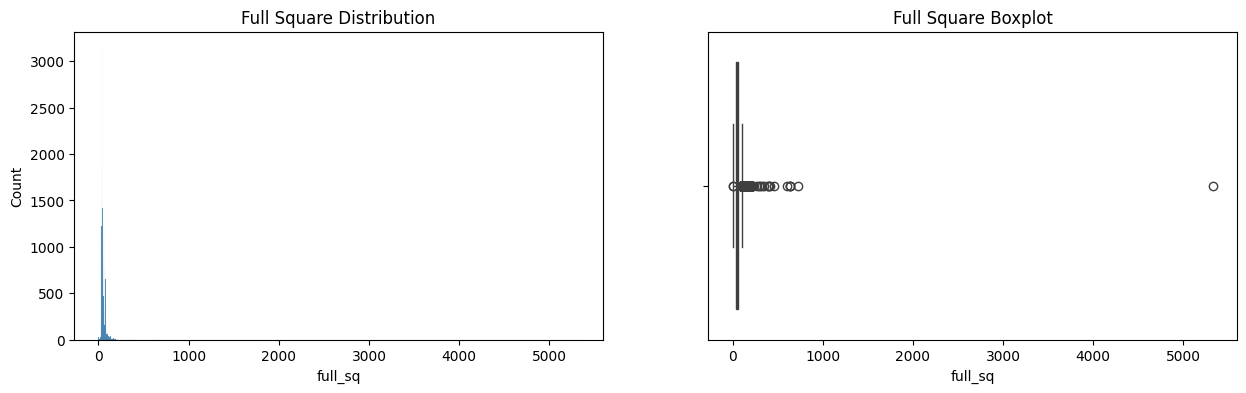

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

Врага нужно знать в лицо! Запомните эти картинки: именно так выглядят типичные графики распределений с выбросами в данных. Гистограмма, реализованная в seaborn, автоматически выбирает число столбцов, необходимое для наилучшей визуализации распределения. Когда признак содержит выбивающиеся значения, число столбцов становится очень велико и в итоге получается такая «кракозябра». 

По этой же причине получается сплюснутая под весом выбросов коробчатая диаграмма. Она помогает более чётко увидеть потенциальные аномалии, которые находятся за пределами усов (1.5 межквартильных размаха).

Визуализация помогает определить наличие выбросов. Для того чтобы их найти, можно воспользоваться статистическими подходами. 

Одним из таких подходов является метод межквартильного размаха (его еще называют методом Тьюки), который используется для построения коробчатой диаграммы.

Алгоритм метода:

→ вычислить 25-ый и 75-ый квантили (первый и третий квартили) — и  для признака, который мы исследуем;

→ вычислить межквартильное расстояние: IQR=Q75-Q25;

→ вычислить верхнюю и нижнюю границы Тьюки:
bound_lower=Q25-1.5*IQR
bound_upper=Q75+1.5*IQR 

→ найти наблюдения, которые выходят за пределы границ .

В соответствии с этим алгоритмом напишем функцию outliers_iqr(), которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.

In [26]:
def outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=True):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

✍️ Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:

In [11]:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


На первый взгляд — стерильно. Однако если присмотреться, то коробчатая диаграмма всё ещё продолжает говорить, что в данных есть одиночные выбросы с обеих сторон от границ. К тому же у нас сильно урезался диапазон жилой площади — максимальная площадь составляет около 100 кв. м. 

?
Как же так, неужели метод не работает?

Причина кроется в том, что после удаления выбросов квартили рассчитываются заново по новым данным, и так оказалось, что из-за свойств распределения были снова найдены точки, которые считаются выбросами.

Классический метод межквартильного размаха не учитывает особенностей распределения! Он требует, чтобы данные были распределены плюс-минус нормально (гистограмма должна быть похожа на колокол) и требует от распределения примерной симметричности (чтобы у гистограммы были одинаковые хвосты в обе стороны).

У нас же распределение (даже после отсечения выбросов) отличается от заявленных критериев. Оно несимметрично: правый хвост изначального распределения гораздо длиннее левого (для Москвы вполне естественны квартиры с площадью свыше 100 квадратных метров) и вовсе не колоколообразно. Попросту говоря, выбор метода поиска не оправдал себя.

Но не стоит расстраиваться! Никто не говорил, что вы должны должны ограничиваться только 1.5 межквартильных размахов. Вы можете сами подбирать число размахов влево и/или вправо и таким образом отбирать выбросы, учитывая особенности ваших данных. 

МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

Последний метод, который мы рассмотрим, — это метод, основанный на правиле трёх сигм для нормального распределения. 

А что делать, если данные не распределены нормально? 

На такой случай есть один трюк. Иногда для распределений, похожих на логнормальное, может помочь логарифмирование. Оно может привести исходное распределение к подобию нормального. Причем, основание логарифма может быть любым.

✍️ Рассмотрим логарифмирование на примере. 

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.

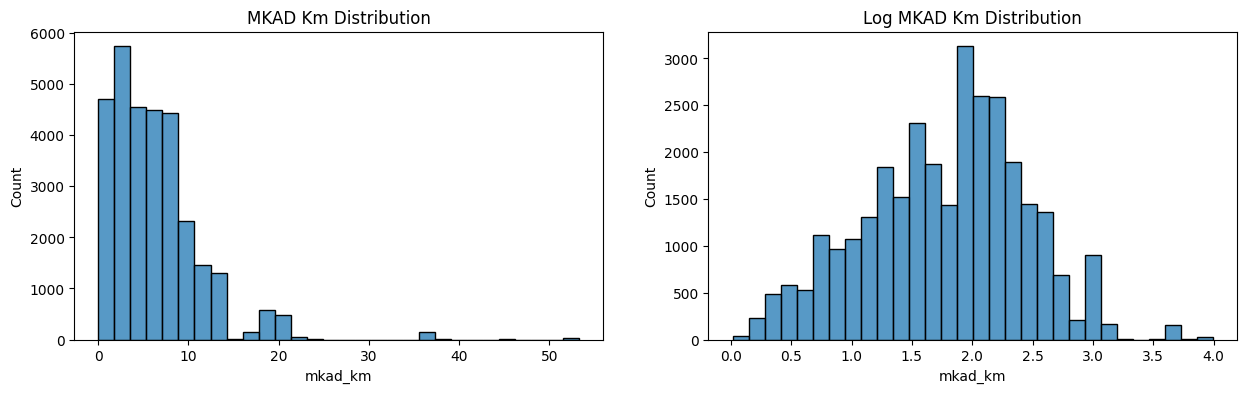

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

Что мы тут видим? 

Левое распределение напоминает логнормальное распределение с наличием потенциальных выбросов-«пеньков», далеко отстоящих от основной массы наблюдений.

Взяв натуральный логарифм от левого распределения, мы получаем правое, которое напоминает слегка перекошенное нормальное. Слева от моды (самого высокого столбика) наблюдается чуть больше наблюдений, нежели справа. По-научному это будет звучать так: «распределение имеет левостороннюю асимметрию».

✏️ Примечание: Численный показатель асимметрии можно вычислить с помощью метода:

Асимметрия распределения называется правосторонней, если она положительная

Асимметрия распределения называется левосторонней, если она отрицательная

Давайте реализуем алгоритм метода z-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание  (среднее) и стандартное отклонение  признака ;

→ вычислить нижнюю и верхнюю границу интервала как:

→ найти наблюдения, которые выходят за пределы границ.

✍️ Напишем функцию outliers_z_score(), которая реализует этот алгоритм. 

На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

In [17]:
def outliers_z_score(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов:

In [18]:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', left=3, right=3.5, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала . Вертикальные линии можно построить с помощью метода axvline(). Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

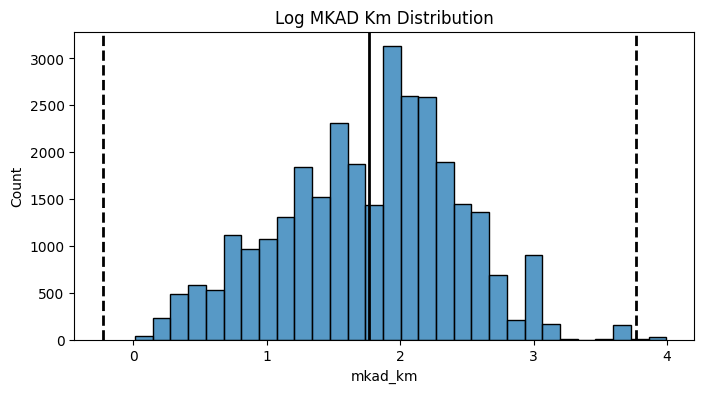

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

РЕЗЮМЕ ПО МЕТОДАМ ПОИСКА ВЫБРОСОВ

Мы рассмотрели классические методы выявления аномальных данных. Как вы сами поняли, каждый из них имеет свои преимущества и недостатки.

Метод ручного поиска тяжело автоматизировать, однако вы сами организовываете проверки, следите за процессом отсеивания выбросов и руководствуетесь не только статистикой, но и здравым смыслом. К тому же из всех представленных только этот метод способен выявить логические нестыковки в данных (например, общая площадь меньше жилой или число этажей более 77 в районе, где нет таких зданий). Обычно этот метод используется в комплексе с другими, чтобы удостовериться в том, что найденные данные действительно являются выбросами, и произвести логическую очистку, на которую неспособны другие методы.

Методы межквартильного размаха и z-отклонений довольно просты в реализации и основаны на стройной математической теории, а не на эвристиках. Но это их преимущество и недостаток. Оба метода разработаны для данных, распределённых приблизительно нормально. Проблема в том, что далеко не всё в мире имеет нормальное распределение. Необходимо внимательно «рыться» в данных, совершать дополнительные преобразования, чтобы привести их хотя бы к подобию нормального распределения, либо подбирать границы методов, чтобы учитывать особенности распределений. В противном случае методы начинают считать выбросами всё, что не вписывается в жёсткие границы, и вы рискуете лишиться важных данных! Учитывайте это в своей работе и всегда проверяйте результаты.